# Diffusion for noobs
## aka Step-by-Step Diffusion meets Simon Prince's 1D Diffusion Tutorial

First, we're going to need some data. We'll start with UDL's mixture of 1D Gaussians



In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap
from operator import itemgetter
#from PIL import Image
from IPython.display import Image as dispImage
from IPython.display import clear_output
from scipy import stats

# True distribution is a mixture of four Gaussians
def norm_pdf(x, mu, sigma):
    return np.exp(-0.5 * (x-mu) * (x-mu) / (sigma * sigma)) / np.sqrt(2*np.pi*sigma*sigma)
class TrueDataDistribution:
  # Constructor initializes parameters
  def __init__(self):
    self.mu = [1.5, -0.216, 0.45, -1.875]
    self.sigma = [0.3, 0.15, 0.525, 0.075]
    self.w = [0.2, 0.3, 0.35, 0.15]

  # Return PDF
  def pdf(self, x):
    return(self.w[0] *norm_pdf(x,self.mu[0],self.sigma[0]) +  self.w[1] *norm_pdf(x,self.mu[1],self.sigma[1]) + self.w[2] *norm_pdf(x,self.mu[2],self.sigma[2]) + self.w[3] *norm_pdf(x,self.mu[3],self.sigma[3]))

  # Draw samples
  def sample(self, n):
    hidden = np.random.choice(4, n, p=self.w)
    epsilon = np.random.normal(size=(n))
    mu_list = list(itemgetter(*hidden)(self.mu))
    sigma_list = list(itemgetter(*hidden)(self.sigma))
    return mu_list + sigma_list * epsilon

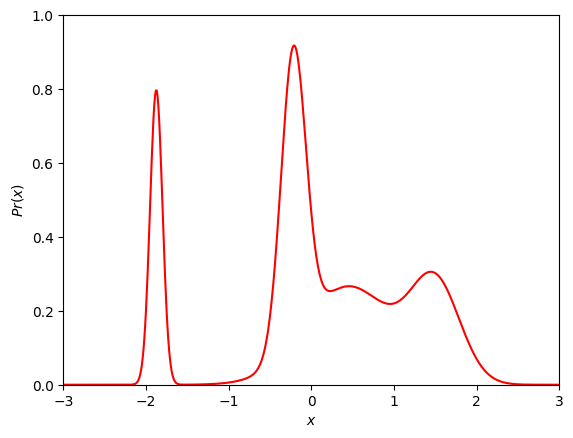

In [2]:
# Define ground truth probability distribution that we will model
true_dist = TrueDataDistribution()
# Let's visualize this
x_vals = np.arange(-3,3,0.01)
pr_x_true = true_dist.pdf(x_vals)
fig,ax = plt.subplots()
ax.plot(x_vals, pr_x_true, 'r-')
ax.set_xlabel("$x$")
ax.set_ylabel("$Pr(x)$")
ax.set_ylim(0,1.0)
ax.set_xlim(-3,3)
plt.show()

Broadly speaking, our goal is to be able to produce samples from some complex (& high dimensional) distribution, whose true parameters are unknown. The trick that Diffusion models employ is that they learn to **progressively** transform from an easy-to-sample distribuion (typically a Gaussian) to a complex distribution. By progressively transform, I mean that instead of trying to directly sample from the target distribution given some sample from our Gaussian, they decompose the problem into a sequence of sampling steps.

Ok that's nice, but how do we actually do that? We define a **forward process** which corrupts our data and then learn to approximate a **reverse process** that undoes the corruption.

Starting with the **forward process**, we sample some $x\sim p^{*}(x)$ (our target distribution). Next, we set $z_{0}=x$, define our corrupting process as <br /> $z_{t+1}=\sqrt{1-\beta}z_{t}+\sqrt{\beta}\epsilon, \epsilon\sim\mathcal{N}(0,\mathbf{I})$. This process iteratively adds Gaussian noise with variance $\beta$ and since we scale $x_{t}$ with $\sqrt{1-\beta}$, if $x$ was normalised to have variance 1, then we will maintain unit variance. (This is a useful property to have when training neural networks)

Using our equation, let's diffuse some samples from our ground truth distribution.



In [3]:
def diffuse_one_step(z_t_minus_1,beta):
    epsilon = np.random.normal()
    z_t = np.sqrt(1-beta)*(z_t_minus_1)+np.sqrt(beta)*epsilon
    return z_t

In [4]:
# Generate some samples
n_sample = 10000
np.random.seed(6)
x = true_dist.sample(n_sample)

# Number of time steps
T = 100
# Noise schedule has same value at every time step
beta = 0.01511

# We'll store the diffused samples in an array
samples = np.zeros((T+1, n_sample))
samples[0,:] = x

for t in range(T):
  samples[t+1,:] = diffuse_one_step(samples[t,:], beta)

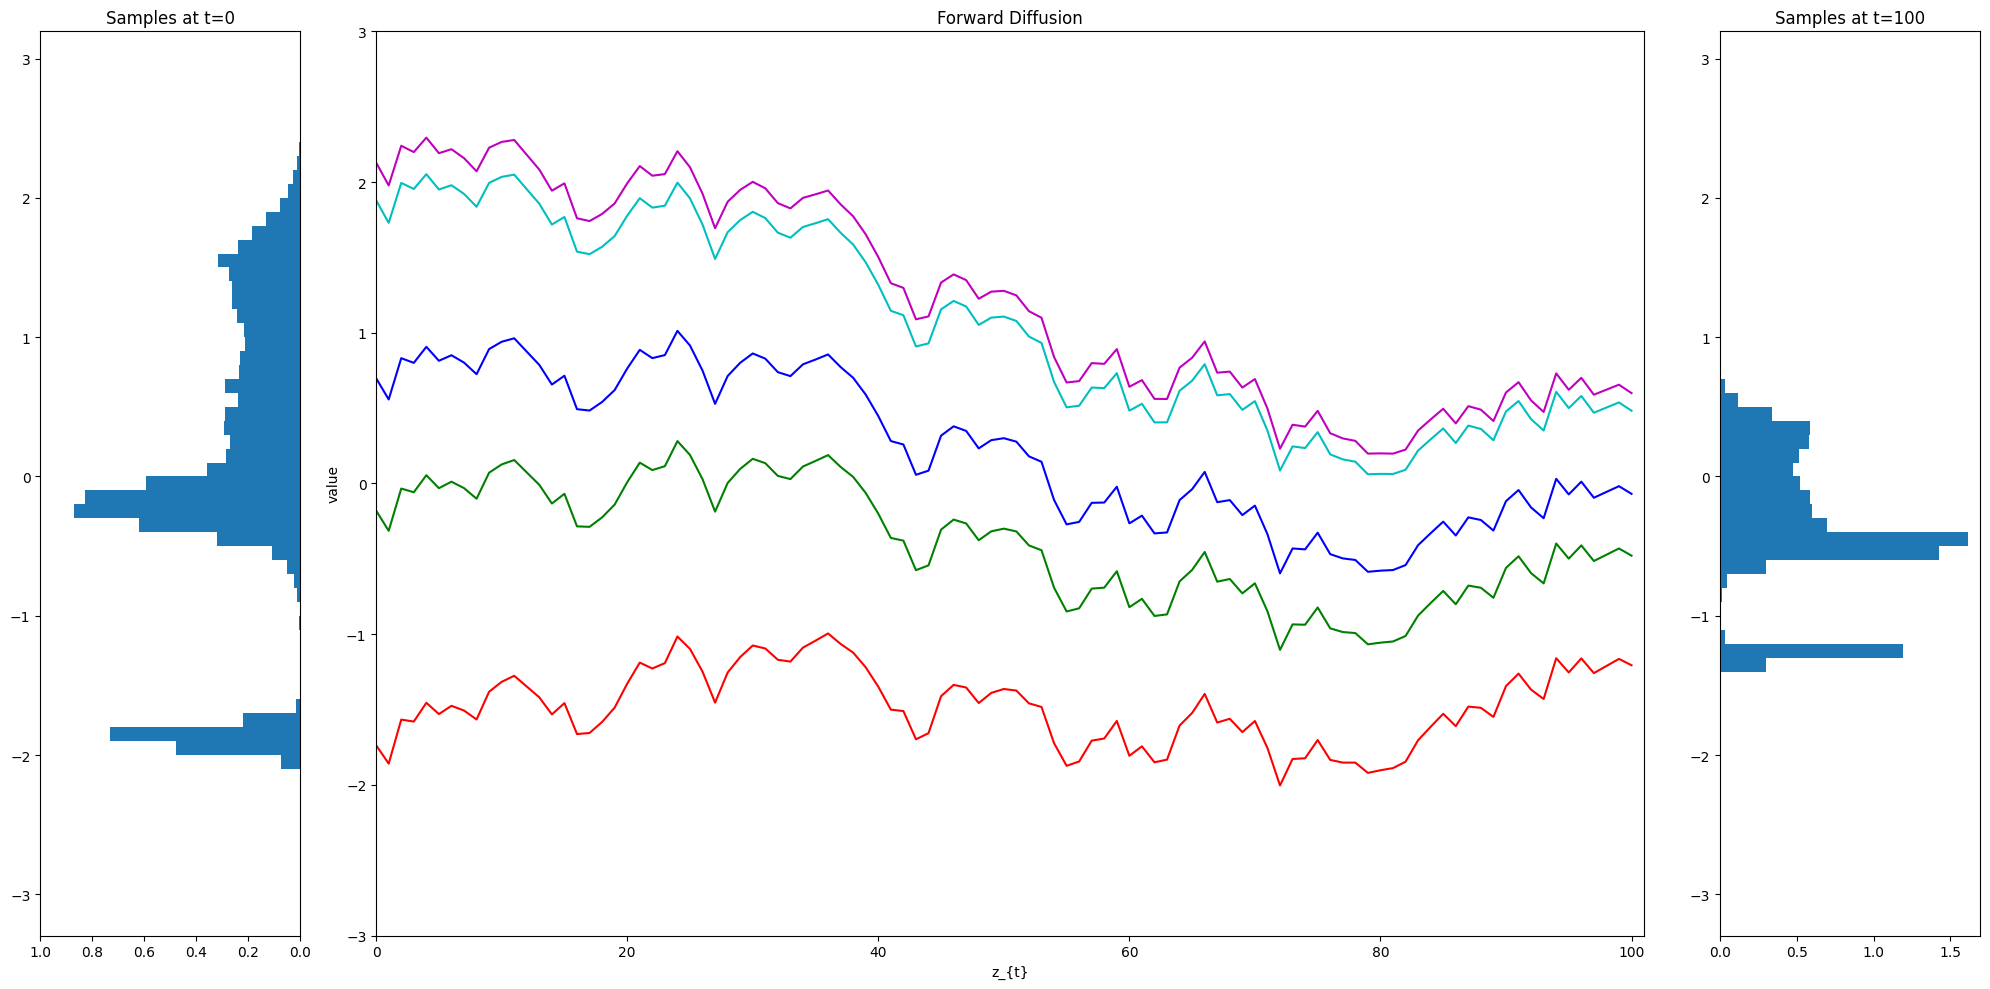

In [5]:
#fig,axs = plt.subplots(1,3,figsize=(20, 10))
fig = plt.figure(figsize=(20, 10))
axs=fig.subplot_mosaic("""ABBBBC
""")

axs["A"].set_title('Samples at t=0')
axs["A"].hist(x , bins=np.arange(-3,3, 0.1), density = True,orientation='horizontal')
axs["A"].set_xlim(1.0,0)

axs["C"].set_title('Samples at t=100')
axs["C"].hist(samples[100,:] , bins=np.arange(-3,3, 0.1), density = True,orientation='horizontal')

t_vals = np.arange(0,T+1,1)
axs["B"].set_title("Forward Diffusion")
axs["B"].plot(t_vals,samples[:,0],'r-')
axs["B"].plot(t_vals,samples[:,1],'g-')
axs["B"].plot(t_vals,samples[:,2],'b-')
axs["B"].plot(t_vals,samples[:,3],'c-')
axs["B"].plot(t_vals,samples[:,4],'m-')
axs["B"].set_ylim([-3,3])
axs["B"].set_xlim([0,T+1])
axs["B"].set_ylabel('value')
axs["B"].set_xlabel('z_{t}')
plt.tight_layout()
plt.show()

What can we see from this? Our samples from $p^{*}(x)$ all move toward a more concentrated distribution. As you might expect, as we increase $T$, the number of steps we run our forward process for, our distribution of samples at $t=100$ starts to look more and more like a Gaussian.

Before we move onto the reverse process, there's one extremely important property of diffusion models that we need to discuss. In order to train a diffusion model we will need to generate samples from the forward process. However, since we're diffusing one step at a time, samples at larger values of $t$ require more function evaluations to generate. However, there are some very useful properties of Gaussian distributions that we can exploit so that we can generate samples at **any** $t$ in the forward process with a single function evaluation.

### Key Property 1: There exists a closed-form expression for $q(z_{t}|x)$:
Consider the first two steps of the forward process: <br/>

$z_{1}$ = $\sqrt{1-\beta}\cdot x +\sqrt{\beta}\epsilon_{1}$<br/>
$z_{2}$ = $\sqrt{1-\beta}\cdot z_{1} +\sqrt{\beta}\epsilon_{2}$<br>

By substitution of $z_{1}$ (1) and $1-1=0$ (2): <br/>

$z_{2}$ = $\sqrt{1-\beta}\left(\sqrt{1-\beta}\cdot x + \sqrt{\beta}\epsilon_{1}\right) +\sqrt{\beta}\epsilon_{2}$ (1)<br/>
$z_{2}$ = $\sqrt{1-\beta}\left(\sqrt{1-\beta}\cdot x + \sqrt{1-(1-\beta)}\epsilon_{1}\right) +\sqrt{\beta}\epsilon_{2}$ (2)<br/>
$z_{2}$ = $\sqrt{(1-\beta)(1-\beta)}\cdot x + \sqrt{1-\beta-(1-\beta)(1-\beta)}\cdot \epsilon_{1} + \sqrt{\beta}\cdot \epsilon_{2}$<br/>

Now we are ready to use the fact that our noise is from a normal distribution. Since both samples are independent samples with mean-zero, we can express the noise that we add to our first term, as a sample from a distribution that is the sum of the two normals. This will be a normal distribution with mean-zero and variance equal to the sum of the variances $1-\beta-(1-\beta)(1-\beta)$ and $\beta$: <br/> $\mathcal{N}(0, (1-(1-\beta)^{2})\mathbf{I})$<br/>
Hence we can write $z_{2}$ as: <br/>
$z_{2}$ = $\sqrt{(1-\beta)(1-\beta)}\cdot x + \sqrt{1-(1-\beta)^{2}}\cdot \epsilon$, $\epsilon \sim \mathcal{N}(0,\mathbf{I})$

It can be shown that by repeated substitution, we can calculate any $z_{t}$ from $x$: <br/>
$z_{t}=\sqrt{\alpha_{t}}\cdot x + \sqrt{1-\alpha_{t}}\cdot \epsilon$, where $\alpha_{t}=(1-\beta)^{t}$

This expression is known as the _diffusion kernel_.


In [6]:
def diffusion_kernel(x,t,beta):
    alpha_t = np.pow((1-beta),t)
    mean = np.sqrt(alpha_t)*x
    std = np.sqrt(1-alpha_t)
    return mean, std

Using our diffusion kernel let's visualise $q(z_{t}|x)$ as $t$ increases. To really get a sense of it, try a few different values of x.

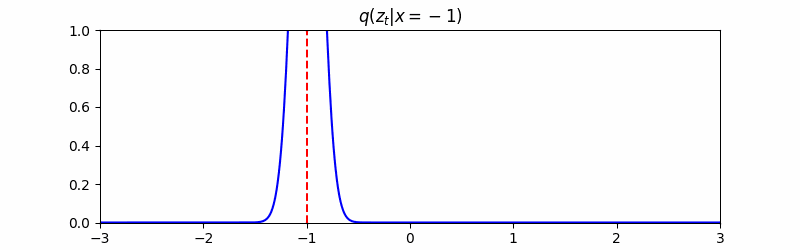

In [7]:
x=-1
plt.ioff()
fig, ax = plt.subplots()
fig.set_size_inches(8,2.5)
plt.title(f'$q(z_{"t"}|x={x})$')
plt.axvline(x,linestyle='--',color='red')
artists=[]

x_plot_vals = np.arange(-3,3,0.01)
diffusion_kernels = np.zeros((T+1,len(x_plot_vals)))
dk_mean_all = np.ones((T+1,1))*x
dk_std_all = np.zeros((T+1,1))
for t in range(T):
    dk_mean_all[t+1], dk_std_all[t+1] = diffusion_kernel(x,t+1,beta)
    diffusion_kernels[t+1,:] =  norm_pdf(x_plot_vals, dk_mean_all[t+1], dk_std_all[t+1])
    #ax.axes.annotate(f't={t+1}',(0,0.5))
    ax.set_xlim([-3,3])
    ax.set_ylim([0,1.0])
    forward  = ax.plot(x_plot_vals,diffusion_kernels[t+1,:],'b-')
    artists.append(forward)

ani = animation.ArtistAnimation(fig=fig, artists=artists, interval=100)
ani.save(filename="/tmp/diffusion_kernel.gif", writer="pillow")

plt.ion()
with open("/tmp/diffusion_kernel.gif",'rb') as f:
    display(dispImage(data=f.read(), format='png'))


The marginal distribution $q(z_{t})$ is the probability of observing a value of $z_{t}$ given the distribution of possible starting points $x$ and the possible diffusion paths for each starting point $x$.

Recall, $\Pr(z_{t})=\int{\Pr(z_{t}|x)\Pr(x)d{x}}$. Since we know our ground truth distribution $p^{*}(x)$ (in general we don't), we can approximate the marginal at each $t$ with a finite set of points.

In [8]:
def diffusion_marginal(x_plot_vals, pr_x_true, t, beta):
    # If time is zero then marginal is just original distribution
    if t == 0:
        return pr_x_true

    # The thing we are computing
    marginal_at_time_t = np.zeros_like(pr_x_true)

    for x0,pr_x in zip(x_plot_vals,pr_x_true):
        #We multiply by 0.01 since that's our step size
        mean_t,std_t = diffusion_kernel(x0,t,beta)
        marginal_at_time_t += 0.01*pr_x*norm_pdf(x_plot_vals,mean_t,std_t)

    return marginal_at_time_t

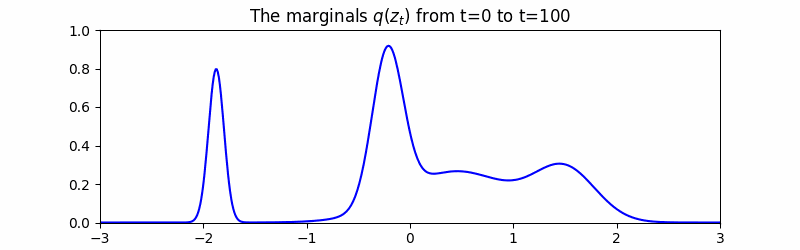

In [9]:
T = 100
sigma = 0.01511

x_plot_vals = np.arange(-3,3,0.01)
marginal_distributions = np.zeros((T+1,len(x_plot_vals)))
plt.ioff()
fig, ax = plt.subplots()
fig.set_size_inches(8,2.5)
ax.set_xlim([-3,3])
ax.set_ylim([0,1.0])
ax.set_title(f'The marginals $q(z_{"t"})$ from t=0 to t=100')

artists=[]

for t in range(T+1):
  marginal_distributions[t,:] = diffusion_marginal(x_plot_vals, pr_x_true , t, sigma)
  cont = ax.plot(x_plot_vals, marginal_distributions[t,:], 'b-')
  artists.append(cont)

ani = animation.ArtistAnimation(fig=fig, artists=artists, interval=100)
ani.save(filename="/tmp/diffusion_marginal.gif", writer="pillow")

plt.ion()
with open("/tmp/diffusion_marginal.gif",'rb') as f:
    display(dispImage(data=f.read(), format='png'))




As one might expect, the marginals of our forward process become more and more Gaussian (since 'corruption' of the data increases as $t\rightarrow \infty$ )

If we could map a sample marginally distributed as $q(z_{t})$ to a sample marginally distributed as $q(z_{t-1})$, then we could reverse the above process! Applying Bayes' rule: <br/>
$q(z_{t-1}|z_{t})$ = $\dfrac{q(z_{t}|z_{t-1})q(z_{t-1})}{q(z_{t})}$ <br/>
Unfortunately, we cannot compute $q(z_{t-1})$, making our reverse process intractable. In our 1D case we can evaluate $q(z_{t-1}|z_{t})$ numerically. Thankfully, for more general cases, we can often approximate each $q(z_{t-1}|z_{t})$ with a Normal distribution. This reduces training to finding the parameters of these distributions, which is a much simpler problem than trying to learn an arbitrary distribution. We will return to this later as it is another key fact that makes diffusion models successful.


<!-- Fortunately, if the per-step noise $\sigma$, is sufficiently small, the conditional distribution $\Pr(z_{t-1}|z_{t})$ is itself close to being Gaussian. So, $\forall t \in [0,\cdots,T]$ and $z\in\mathbb{R}^{d}$, $\exists \mu\in\mathbb{R}^{d}$ such that, <br />
$\Pr(z_{t-1}|z_{t}=z)\approx \mathcal{N}(z_{t-1};\mu,\sigma^{2})$

Now, instead of having to learn some arbitrary distribution, we just need to learn the mean:
$\mu_{t-1}(z_{t})$ ($\mu_{t-1}$ : $\mathbb{R}^{d} \mapsto \mathbb{R}^{d}$). This is a much simpler problem, which can be solved via regression loss:<br />
$\mu_{t-1}(z):=\mathbb{E}\left[z_{t-1}|z_{t}=z\right]$<br />
$\implies \mu_{t-1}= \text{argmin}_{f:\mathbb{R}^{d} \mapsto \mathbb{R}^{d}}$ $\mathbb{E}_{z_{t},z_{t-1}}\left \lVert f(z_{t}) - z_{t-1} \right \rVert_{2}^{2}$<br />
$= \text{argmin}_{f:\mathbb{R}^{d} \mapsto \mathbb{R}^{d}}$ $\mathbb{E}_{z_{t-1},\epsilon\sim\mathcal{N}(0,\sigma^{2})}\left \lVert f(z_{t-1}+\epsilon) - z_{t-1} \right \rVert_{2}^{2}$

Ok. So we just need to learn $T$, functions $\{\mu_{t}\}$. In the training phase, we estimate these functions from i.i.d. samples of $x\sim p^{*}$ by optimising our earlier denoising objective. Then, in order to produce a sample from $p^{*}$, we use the estimated functions to construct the following stochastic reverse sampler: <br />
$\hat{z}_{t-1}\gets \mu_{t-1}(z_{t})+\epsilon,\epsilon\sim\mathcal{N}(0,\frac{1}{T}\sigma^{2}_{q})$, where $\sigma^{2}_{q}$ is the desired terminal variance. -->


Let's now consider $q(z_{t-1}|z_{t},x)$. From Baye's rule, $q(z_{t-1}|z_{t},x)$ = $\dfrac{q(z_{t}|z_{t-1},x)}{q(z_{t-1}|x)}$. By definition of our forward process $q(z_{t}|z_{t-1},x)=q(z_{t},z_{t-1})$. Hence, $q(z_{t-1}|z_{t},x) \propto q(z_{t}|z_{t-1})q(z_{t-1}|x)$.

Using, the following two identities we can reduce $q(z_{t-1}|z_{t},x)$ to a single normal distribution with known parameters:
* $\mathcal{N}(v;\mathbf{Aw},\mathbf{B}) \propto \mathcal{N}(w;(\mathbf{A^{T}B^{-1}A})^{-1}\mathbf{A^{T}B^{-1}v},(\mathbf{A^{T}B^{-1}A})^{-1})$
* $\mathcal{N}(w;\mathbf{c},\mathbf{C})\cdot \mathcal{N}(w;\mathbf{d},\mathbf{D}) \propto \mathcal{N}(w;(\mathbf{A^{-1}+B^{-1}})^{-1}(\mathbf{A^{-1}a+B^{-1}b}),(\mathbf{A^{-1}+B^{-1}})^{-1})$

This gives us: $q(z_{t-1}|z_{t},x)$ = $\mathcal{N}\left(z_{t-1};\dfrac{(1-\alpha_{t-1})}{1-\alpha_{t}}\sqrt{1-\beta}z_{t}+\dfrac{\sqrt{\alpha_{t-1}}\beta}{1-\alpha_{t}}x,\dfrac{\beta(1-\alpha_{t-1})}{1-\alpha_{t}}\mathbf{I}\right)$

We can now use this ground truth reverse process to 'train' a NonParametric Model from UDL.

In [10]:
# Compute mean and variance q(z_{t-1}|z_{t},x)
def ground_truth_reverse_conditional_diffusion_distribution(x,z_t,t,beta):
    alpha_t_minus_1 = np.power(1-beta,t-1)
    alpha_t = alpha_t_minus_1 * (1-beta)
    cd_mean_t = (z_t*(1-alpha_t_minus_1)/(1-alpha_t)*np.sqrt(1-beta)
                 +(x*np.sqrt(alpha_t_minus_1)*beta)/(1-alpha_t))
    cd_std_t = beta*(1-alpha_t_minus_1)/(alpha_t)

    return cd_mean_t, cd_std_t

#Data pairs for the NonParametric Model
def get_data_pairs(x_train,t,beta):
    # Find diffusion kernel for every x_train and draw samples
    dk_mean, dk_std = diffusion_kernel(x_train, t, beta)
    z_t = np.random.normal(size=x_train.shape) * dk_std + dk_mean
    # Find conditional diffusion distribution for each x_train, z pair and draw samples
    cd_mean, cd_std  = ground_truth_reverse_conditional_diffusion_distribution(x_train,z_t,t,beta)
    if t == 1:
      z_tminus1 = x_train
    else:
      z_tminus1 = np.random.normal(size=x_train.shape) * cd_std + cd_mean

    return z_t, z_tminus1

In [11]:
# Directly from UDL
# This code is really ugly!  Don't look too closely at it!
# All you need to know is that it is a model that trains from pairs zt, zt_minus1
# And can then predict zt_minus1
class NonParametricModel():
   # Constructor initializes parameters
  def __init__(self):

    self.inc = 0.01
    self.max_val = 3.0
    self.model = []

  # Learns a model that predicts z_t_minus1 given z_t
  def train(self, zt, zt_minus1):
      zt = np.clip(zt,-self.max_val,self.max_val)
      zt_minus1 = np.clip(zt_minus1,-self.max_val,self.max_val)
      bins = np.arange(-self.max_val,self.max_val+self.inc,self.inc)
      numerator, *_ = stats.binned_statistic(zt, zt_minus1-zt, statistic='sum',bins=bins)
      denominator, *_ = stats.binned_statistic(zt, zt_minus1-zt, statistic='count',bins=bins)
      self.model = numerator / (denominator + 1)

  def predict(self, zt):
      bin_index = np.floor((zt+self.max_val)/self.inc)
      bin_index = np.clip(bin_index,0, len(self.model)-1).astype('uint32')
      return zt + self.model[bin_index]

In [12]:
# Sample data from distribution (this would usually be our collected training set)
n_sample = 100000
x_train = true_dist.sample(n_sample)

# Define model parameters
T = 100
beta = 0.01511

all_models = []
for t in range(0,T):
    clear_output(wait=True)
    display("Training timestep %d"%(t))
    zt,zt_minus1 = get_data_pairs(x_train,t+1,beta)
    all_models.append(NonParametricModel())
    # The model at index t maps data from z_{t+1} to z_{t}
    all_models[t].train(zt,zt_minus1)

'Training timestep 99'

In [13]:
def sample_non_parametric(model, T, sigma_t, n_samples):
    # Create the output array
    # Each row represents a time step, first row will be sampled data
    # Each column represents a different sample
    samples = np.zeros((T+1,n_samples))

    samples[T,:]=np.random.normal(size=n_samples)


    # For t=100...99..98... ...0
    for t in range(T,0,-1):
        clear_output(wait=True)
        display("Predicting z_{%d} from z_{%d}"%(t-1,t))
        # Predict samples[t-1,:] from samples[t,:] using the appropriate model
        samples[t-1,:] = model[t-1].predict(samples[t,:])#np.zeros((1,n_samples))


        # If not the last time step
        if t>0:
            # Add noise to the samples at z_t-1 we just generated with mean zero, standard deviation sigma_t
            samples[t-1,:] = samples[t-1,:] + np.random.normal(loc=0,scale=sigma_t,size=n_samples)

    return samples

With our NonParametric model we can quite accurately reverse our forward process.

'Predicting z_{0} from z_{1}'

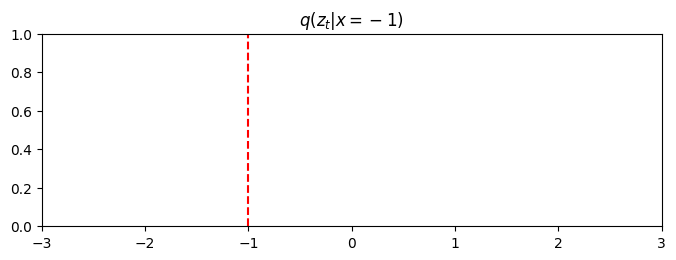

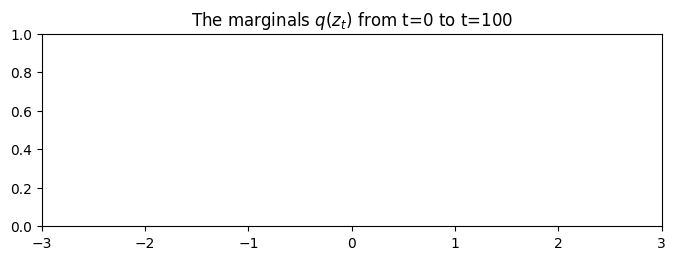

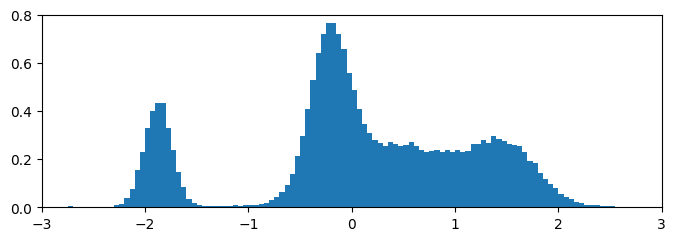

In [14]:
sigma =0.12288
n_samples = 100_000
samples=sample_non_parametric(all_models,T,sigma,n_samples)#sample(all_models,T,sigma,n_samples)

# Plot the data
sampled_data = samples[0,:]
bins = np.arange(-3,3.05,0.05)

fig,ax = plt.subplots()
fig.set_size_inches(8,2.5)
ax.set_xlim([-3,3])
plt.hist(sampled_data, bins=bins, density =True)
ax.set_ylim(0, 0.8)
plt.show()

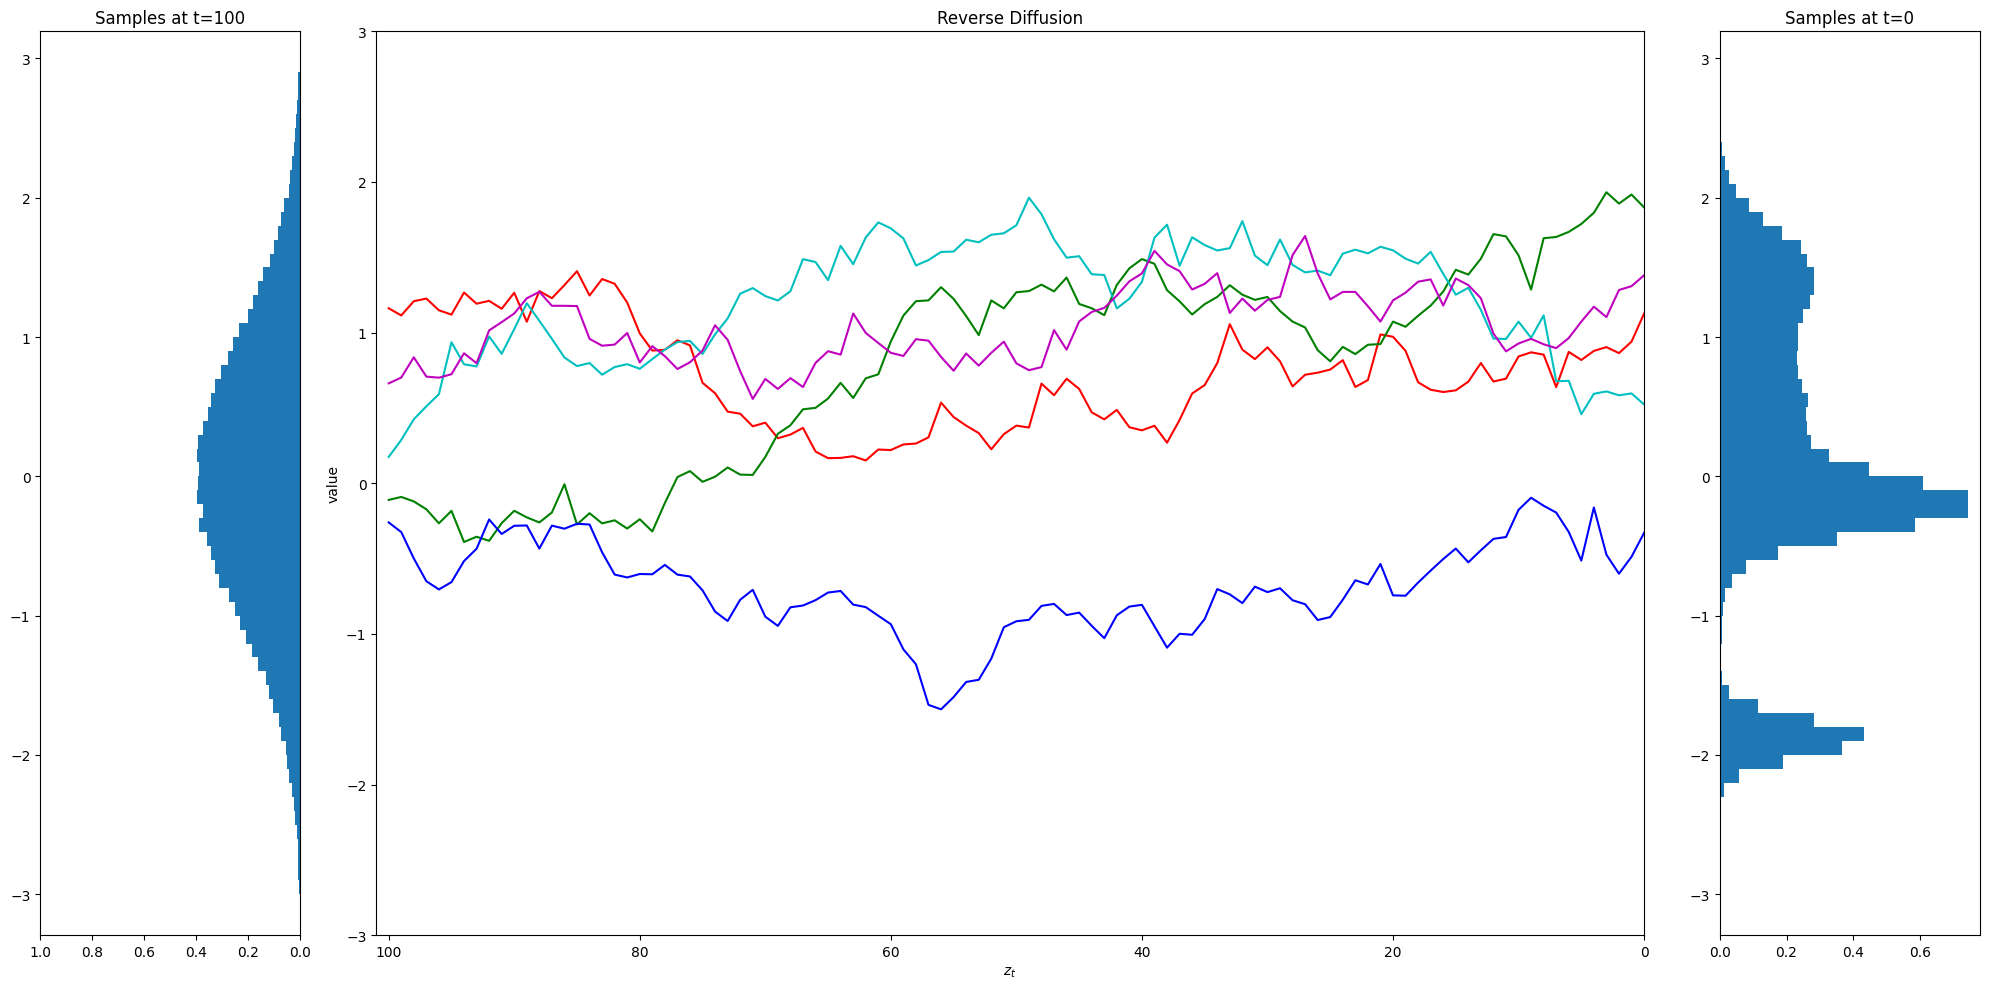

In [15]:
fig = plt.figure(figsize=(20, 10))
axs=fig.subplot_mosaic("""ABBBBC
""")

axs["A"].set_title('Samples at t=100')
axs["A"].hist(samples[100,:] , bins=np.arange(-3,3, 0.1), density = True,orientation='horizontal')
axs["A"].set_xlim(1.0,0)

axs["C"].set_title('Samples at t=0')
axs["C"].hist(samples[0,:] , bins=np.arange(-3,3, 0.1), density = True,orientation='horizontal')

t_vals = np.arange(0,T+1,1)
axs["B"].set_title("Reverse Diffusion")
axs["B"].plot(t_vals,samples[:,0],'r-')
axs["B"].plot(t_vals,samples[:,1],'g-')
axs["B"].plot(t_vals,samples[:,2],'b-')
axs["B"].plot(t_vals,samples[:,3],'c-')
axs["B"].plot(t_vals,samples[:,4],'m-')
axs["B"].set_ylim([-3,3])
axs["B"].set_xlim([T+1,0])
axs["B"].set_ylabel('value')
axs["B"].set_xlabel(f'$z_{"t"}$')
plt.tight_layout()
plt.show()

Pretty cool but this obviously won't scale to images. We'll therefore need to develop a training procedure that works with neural networks. Recall, our earlier note that we can approximate $q(z_{t-1}|z_{t})$ as a normal distribution. We'll expand on it further now.

### Key Fact 2: We can approximate $q(z_{t-1}|z_{t})$ with a normal distribution

So far we've talked about our diffusion processes in terms of discrete steps, however it will be useful at times to think of our sequence $z_{0},z_{1},\dots,z_{T}$ as the _discretisation_ of a time evolving function $z(x,t)$ that starts from $p^{*}(x)$ at $t=0$ and ends at the noisy distribution $q(z_{T})$ at time $t=1$: <br/>
$p(x,k\Delta t)=p_{k}(x)$, where $\Delta t=\frac{1}{T}$<br/>

The number of steps $T$ controls the fineness of the discretisation. In order to ensure that the variance of $q(z_{T})$ is independent of the number of discretisation steps, we scale our variances by $\Delta t$: <br/>
$z_{k}=z_{k-1}+\epsilon$, $\epsilon\sim\mathcal{N}(0,\Delta t\beta_{q})$, where $\beta_{q}$ is the desired terminal variance.
<!-- TODO -->
<!-- For the argument for **Key Fact 2**, we will adjust our notation. We will now use $t$ to denote a value in $[0,\Delta t,2\Delta t,\dots,T\Delta t=1]$,the _time_, rather than an _index_. So $z_{t}$ will mean $z$ at a discretised time $t$. Now we're ready to give an argument for this fact:

Let $q_{t-\Delta t}(z)$ be an arbitrary, sufficiently-smooth density over $\mathbb{R}^{d}$. Consider the joint distribution of $(z_{t-\Delta t},z_{t})$, where $z_{t-\Delta t} \sim q_{t-\Delta t}$ and $z_{t} \sim \sqrt{1-\beta}z_{t-\Delta t}+\sqrt{\beta}\epsilon, \epsilon \sim \mathcal{N}(0,\Delta t\mathbf{I})$. Starting with Bayes' Rule, $q(z_{t-\Delta t}|z_{\Delta t})=\dfrac{q(z_{t}|z_{t-\Delta t})q(z_{t-\Delta t})}{q(z_{t})}$, next we take logs of both sides.<br/>
$\log q(z_{t-\Delta t}|z_{\Delta t}) = \log q(z_{t}|z_{t-\Delta t}) + \log q(z_{t-\Delta t}) - \cancel{\log q(z_{t})}$ <br/>
We're going to think of $z_{t}$ as a constant in this derivation, since we are interested in the conditional probability as a function of $z_{t-\Delta t}$. Terms like $\log q(z_{t})$ (additive constants in the log), serve as normalising factors and will be dropped. We will also drop terms of order $\mathcal{O}(\Delta t)$(why?). 
$\log q(z_{t-\Delta t}|z_{\Delta t})=\log q(z_{t}|z_{t-\Delta t})$ -->

Having established...

In [16]:
import torch
import torch.nn as nn

device = "cuda:0" if torch.cuda.is_available() else "cpu"


class MuNet(nn.Module):
    def __init__(self, h):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1,2*h),
            nn.ReLU(),
            nn.Linear(2*h,h),
            nn.ReLU(),
            nn.Linear(h,1),
            #nn.ReLU(),
        )
    def forward(self,x):
        return self.layers(x)

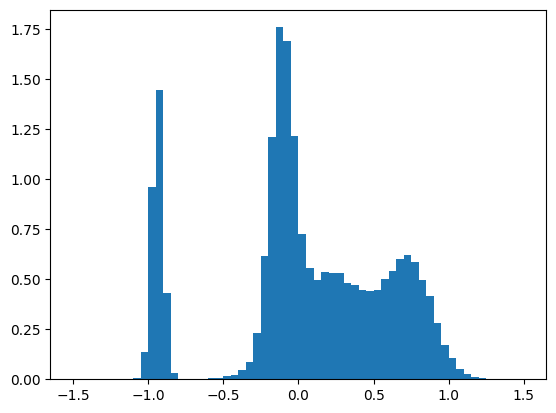

In [17]:
x_train = np.array(true_dist.sample(n_samples)) #
x_train = 1/2*x_train
plt.hist(x_train, bins=np.arange(-1.50,1.55,0.05), density = True)
plt.show()
np.random.shuffle(x_train)

In [18]:
mus = [MuNet(16).to(device) for i in range(T)]
n_samples = 100_000
x_train = np.array(true_dist.sample(n_samples))
x_train = (1/2)*(x_train)
batch_size = 4096
n_epochs= 10
beta = 0.01511 #Variance of forward process
sigma = 0.12288  #Std of reverse process
lr=1e-2


for t,mu_model in enumerate(mus):
    t=t+1
    alpha_t = np.pow((1-beta),t)
    alpha_t_minus_1 = np.pow((1-beta),t-1)
    optimiser = torch.optim.Adam(mu_model.parameters(),lr=lr)
    for e in range(n_epochs):
        print(f"*****Training mu_{t}*****")
        running_loss = 0
        np.random.shuffle(x_train)
        for i in range(n_samples//batch_size+1):
            optimiser.zero_grad()
            batch_min_idx = i*batch_size
            batch_max_idx = min(n_samples-1,(i+1)*batch_size)
            inputs = torch.tensor(x_train[batch_min_idx:batch_max_idx],device=device,dtype=torch.float32).unsqueeze(1)
            noised_inputs = np.sqrt(alpha_t)*inputs + np.sqrt(1-alpha_t)*torch.randn_like(inputs)
            labels = (
                (noised_inputs*(1-alpha_t_minus_1)/(1-alpha_t))*np.sqrt(1-beta) + ((inputs*np.sqrt(alpha_t_minus_1)*beta)/(1-alpha_t)))
            
            outputs=mu_model(noised_inputs)
            #(1/2*sigma**(2))*
            loss = torch.nn.functional.mse_loss(outputs,labels)
            loss.backward()
            optimiser.step()
            running_loss += loss.item()
        
            if i%100:
                print(f'[Epoch: {e+1}/{n_epochs} Batch {i}] Loss: {running_loss/100}')
                running_loss=0
            #print(loss)
        clear_output(wait=True)
        #break



*****Training mu_100*****
[Epoch: 10/10 Batch 1] Loss: 5.833627437823452e-07
[Epoch: 10/10 Batch 2] Loss: 2.9324346542125566e-07
[Epoch: 10/10 Batch 3] Loss: 2.8261296392884105e-07
[Epoch: 10/10 Batch 4] Loss: 2.7537102141650395e-07
[Epoch: 10/10 Batch 5] Loss: 2.813260107359383e-07
[Epoch: 10/10 Batch 6] Loss: 2.86570138996467e-07
[Epoch: 10/10 Batch 7] Loss: 2.9425023967633024e-07
[Epoch: 10/10 Batch 8] Loss: 2.897530066547915e-07
[Epoch: 10/10 Batch 9] Loss: 2.83170047623571e-07
[Epoch: 10/10 Batch 10] Loss: 2.8671523978118784e-07
[Epoch: 10/10 Batch 11] Loss: 2.979844430228695e-07
[Epoch: 10/10 Batch 12] Loss: 3.446645860094577e-07
[Epoch: 10/10 Batch 13] Loss: 2.9838382033631204e-07
[Epoch: 10/10 Batch 14] Loss: 2.7654332370730115e-07
[Epoch: 10/10 Batch 15] Loss: 2.943980143754743e-07
[Epoch: 10/10 Batch 16] Loss: 2.92489530693274e-07
[Epoch: 10/10 Batch 17] Loss: 2.839789158315398e-07
[Epoch: 10/10 Batch 18] Loss: 2.8671596737694925e-07
[Epoch: 10/10 Batch 19] Loss: 2.9137732781

In [19]:
def sample(models, T, sigma_t, n_samples):
    # Create the output array
    # Each row represents a time step, first row will be sampled data
    # Each column represents a different sample
    samples = np.zeros((T+1,n_samples))

    #Initialize the samples z_{T} at samples[T,:] from standard normal distribution
    samples[T,:]=np.random.normal(size=n_samples)
    with torch.no_grad():
    # For t=100...99..98... ...0
        for t in range(T,0,-1):
            clear_output(wait=True)
            display("Predicting z_{%d} from z_{%d}"%(t-1,t))
            #Predict samples[t-1,:] from samples[t,:] using the appropriate model
        
            torch_inputs = torch.tensor(samples[t,:],device=device,dtype=torch.float32).view(n_samples,1)
            samples[t-1,:] = models[t-1](torch_inputs).cpu().numpy().squeeze()


            # If not the last time step
            if t>0:
                # TODO Add noise to the samples at z_t-1 we just generated with mean zero, standard deviation sigma_t
                samples[t-1,:] = samples[t-1,:] + np.random.normal(loc=0,scale=sigma_t,size=n_samples)

    return samples

'Predicting z_{0} from z_{1}'

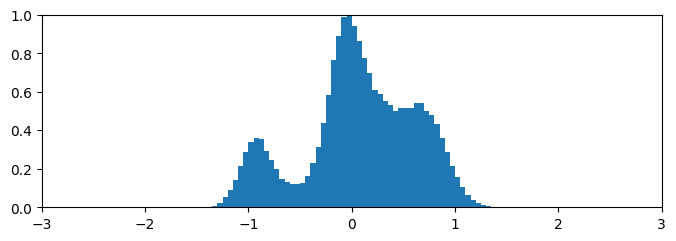

In [20]:
sigma = 0.12288
n_samples = 100_000
samples=sample(mus,T,sigma,n_samples)
samples = samples

# Plot the data
sampled_data = samples[0,:]
bins = np.arange(-3,3.05,0.05)

fig,ax = plt.subplots()
fig.set_size_inches(8,2.5)
ax.set_xlim([-3,3])
plt.hist(sampled_data, bins=bins, density =True)
ax.set_ylim(0, 1.0)
plt.show()

Now that's cool! You may have noticed that the distribution has been approximately scaled into [-1,1]. If we'd like to recover our original data scale, we need only multiply by 2.

As before we can visualise the reverse diffusion paths:

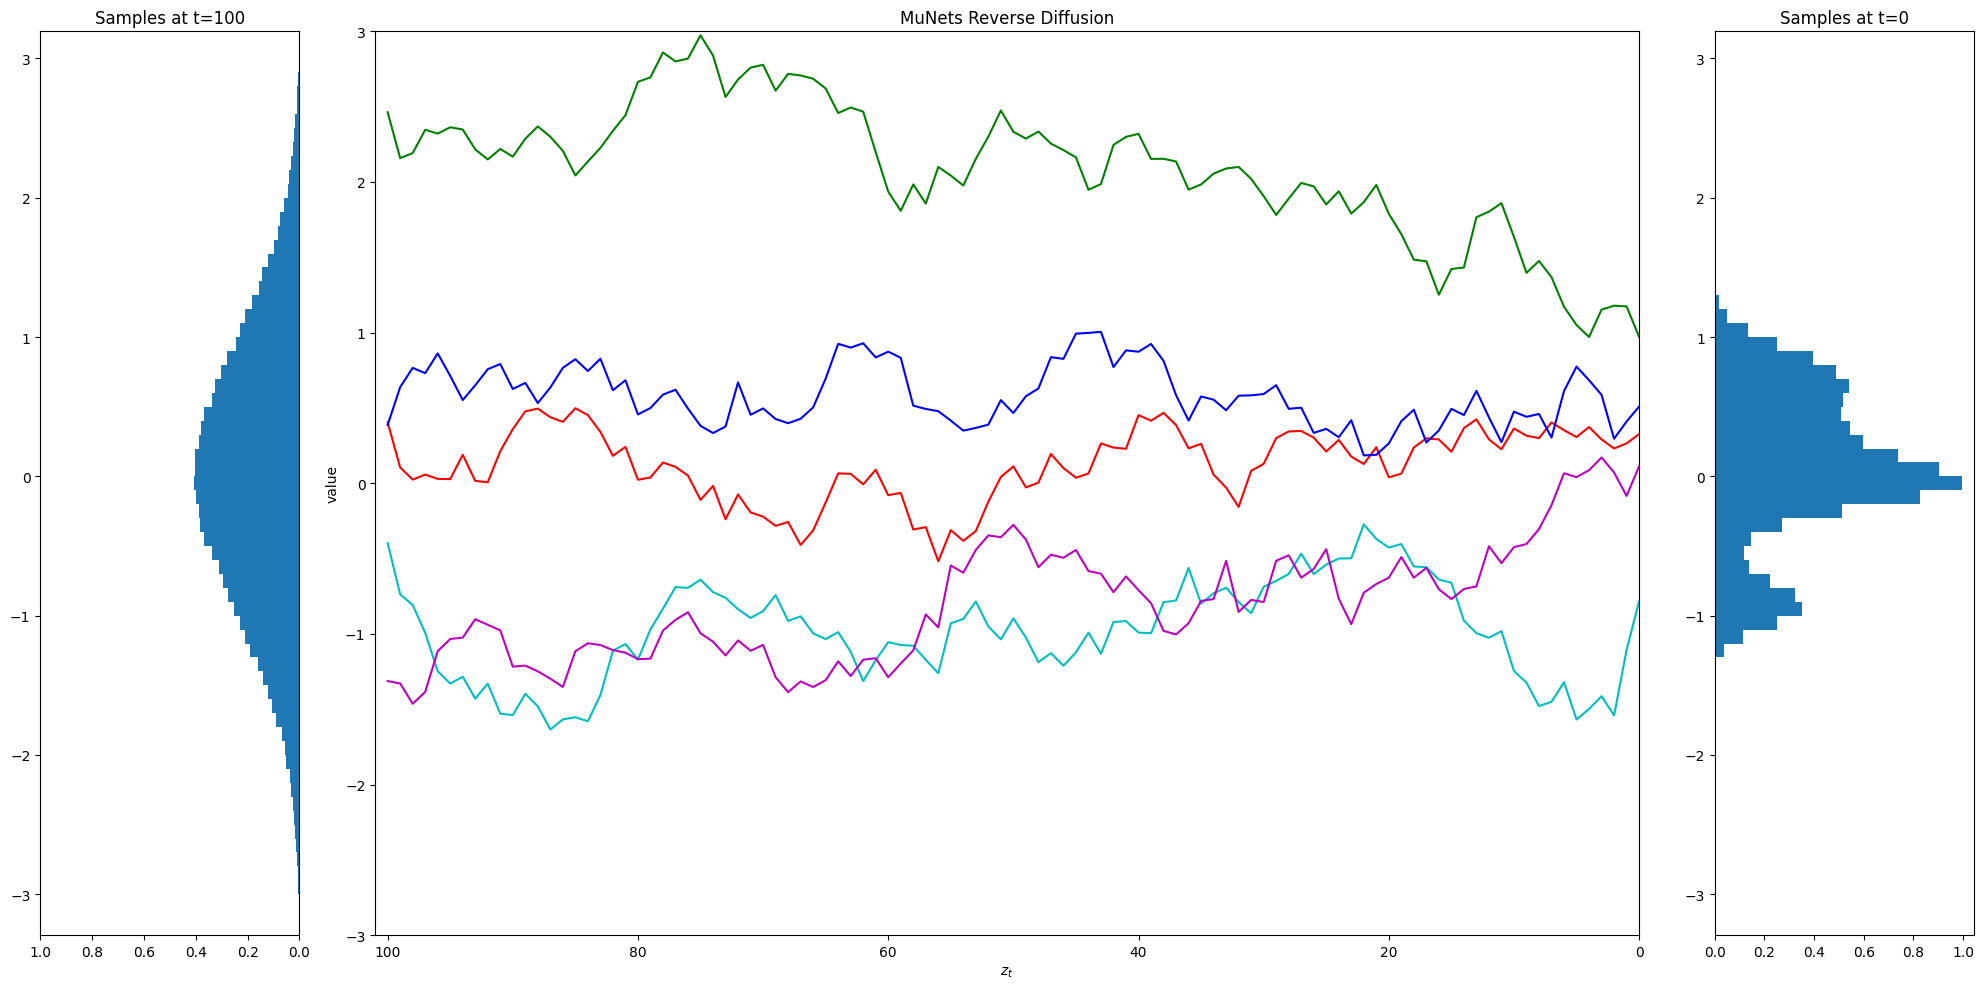

In [21]:
fig = plt.figure(figsize=(20, 10))
axs=fig.subplot_mosaic("""ABBBBC
""")

axs["A"].set_title('Samples at t=100')
axs["A"].hist(samples[100,:] , bins=np.arange(-3,3, 0.1), density = True,orientation='horizontal')
axs["A"].set_xlim(1.0,0)

axs["C"].set_title('Samples at t=0')
axs["C"].hist(samples[0,:] , bins=np.arange(-3,3, 0.1), density = True,orientation='horizontal')

t_vals = np.arange(0,T+1,1)
axs["B"].set_title("MuNets Reverse Diffusion")
axs["B"].plot(t_vals,samples[:,0],'r-')
axs["B"].plot(t_vals,samples[:,1],'g-')
axs["B"].plot(t_vals,samples[:,2],'b-')
axs["B"].plot(t_vals,samples[:,3],'c-')
axs["B"].plot(t_vals,samples[:,4],'m-')
axs["B"].set_ylim([-3,3])
axs["B"].set_xlim([T+1,0])
axs["B"].set_ylabel('value')
axs["B"].set_xlabel(f'$z_{"t"}$')
plt.tight_layout()
plt.show()

Ok so while neural networks can scale to much higher dimensional data, we have an awful lot of them at the moment! Thankfully, we actually only need **1** model to predict all the means! All we need to do is _condition_ our model on the current timestep. In our simple setting we could probably get this to work by just adding the timestep. However, in big fancy models like Stable Diffusion and Flux they use a 'timestep embedding' function. It's not that crazy and we'll just add this _embedding_ to one of our intermediate hidden values. Let's make that modification and train our single neural network.

In [22]:
#https://github.com/CompVis/stable-diffusion/blob/main/ldm/modules/diffusionmodules/model.py

#Here we have it in numpy so that we can easily mess around with it.

def get_timestep_embedding(timesteps,emb_dim):
    half_dim = emb_dim//2
    emb = math.log(10000) / (half_dim - 1)
    emb = np.exp(np.arange(half_dim, dtype=np.float32) * -emb)
    emb = timesteps[:, None] * emb[None, :]
    emb = np.concat([np.sin(emb), np.cos(emb)], axis=1)
    return emb

In [23]:
class TimeMuNet(nn.Module):
    def __init__(self, h,p_dropout):
        super().__init__()
        self.h=h
        self.layer1 = nn.Sequential(
            nn.Linear(1,2*h),
            nn.ReLU(),
        )
        self.dropout = nn.Dropout(p=p_dropout)
        self.last_layers = nn.Sequential(
            nn.Linear(2*h,h),
            nn.ReLU(),
            nn.Linear(h,1),
        )
    # Same function as before except now our half dim is h
    def get_timestep_embedding(self,timesteps):
        timesteps=timesteps.squeeze()# Make sure our timesteps are 1D
        half_dim = self.h
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, dtype=torch.float32) * -emb)
        emb = emb.to(device=timesteps.device)
        emb = timesteps.float()[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
        if self.h % 2 == 1:  # zero pad
            emb = torch.nn.functional.pad(emb, (0,1,0,0))
        return emb
    
    def forward(self,x,t):
        hidden = self.dropout(self.layer1(x))
        time_embedding = self.get_timestep_embedding(t) 
        hidden = hidden + time_embedding #Add it in right after the first layer
        return self.last_layers(hidden)

In [24]:
def get_alpha_t(t,beta):
    return torch.pow((1-beta),t)
def get_alpha_t_minus_1(t,beta):
    return torch.pow((1-beta),t-1)


In [25]:
time_mu_net = TimeMuNet(h=256,p_dropout=0.2).to(device)
n_samples = 200_000
x_train = np.array(true_dist.sample(n_samples))
x_train = (1/2)*(x_train)
batch_size = 4096
n_epochs= 100
beta = 0.01511 #Variance of forward process
sigma = 0.12288  #Std of reverse process
lr=1e-4

time_mu_net.train()
optimiser = torch.optim.AdamW(time_mu_net.parameters(),lr=lr)
for e in range(n_epochs):
    print(f"*****Epoch {e}*****")
    running_loss = 0
    np.random.shuffle(x_train)

    for i in range(n_samples//batch_size+1):
        optimiser.zero_grad()
        batch_min_idx = i*batch_size
        batch_max_idx = min(n_samples-1,(i+1)*batch_size)
        inputs = torch.tensor(x_train[batch_min_idx:batch_max_idx],device=device,dtype=torch.float32).unsqueeze(1)
        timesteps = torch.randint_like(inputs,low=1,high=T,device=device).long()
        alpha_t = get_alpha_t(timesteps,beta)
       
        # break
        alpha_t_minus_1 = get_alpha_t_minus_1(timesteps,beta)

        noised_inputs = torch.sqrt(alpha_t)*inputs + torch.sqrt(1-alpha_t)*torch.randn_like(inputs)
        #print(f"Noised Inputs: {labels}")
        labels = (
            (noised_inputs*(1-alpha_t_minus_1)/(1-alpha_t))*torch.sqrt(torch.tensor(1-beta,device=device)) + ((inputs*torch.sqrt(alpha_t_minus_1)*beta)/(1-alpha_t)))
        #print(f"Labels: {labels}")
        outputs=time_mu_net(noised_inputs,timesteps)
        # print(outputs)
        # 
        # print(labels)
        #(1/2*sigma**(2))*
        loss = torch.nn.functional.mse_loss(outputs,labels)
        # if loss.isnan().any():
        #     break
      
        loss.backward()
        optimiser.step()
        running_loss += loss.item()
    
        if i%10==0:
            print(f'[Epoch: {e+1}/{n_epochs} Batch {i}] Loss: {running_loss/100}')
            running_loss=0
        #print(loss)
    clear_output(wait=True)



*****Epoch 99*****
[Epoch: 100/100 Batch 0] Loss: 9.817701065912843e-06
[Epoch: 100/100 Batch 10] Loss: 0.00010281890863552689
[Epoch: 100/100 Batch 20] Loss: 0.00010234420304186642
[Epoch: 100/100 Batch 30] Loss: 9.965878096409142e-05
[Epoch: 100/100 Batch 40] Loss: 0.00010068165545817464


In [26]:
def sample_from_timemunet(model,T,sigma_t,n_samples):
    # Create the output array
    # Each row represents a time step, first row will be sampled data
    # Each column represents a different sample
    samples = np.zeros((T+1,n_samples))

    #Initialize the samples z_{T} at samples[T,:] from standard normal distribution
    samples[T,:]=np.random.normal(size=n_samples)
    model.eval()
    with torch.no_grad():
    # For t=100...99..98... ...0
        for t in range(T,0,-1):
            clear_output(wait=True)
            display("Predicting z_{%d} from z_{%d}"%(t-1,t))
            #Predict samples[t-1,:] from samples[t,:] using the appropriate model
        
            torch_inputs = torch.tensor(samples[t,:],device=device,dtype=torch.float32).view(n_samples,1)
            samples[t-1,:] = model(torch_inputs,torch.tensor(n_samples*[t-1],device=device)).cpu().numpy().squeeze()


            # If not the last time step
            if t>0:
                # TODO Add noise to the samples at z_t-1 we just generated with mean zero, standard deviation sigma_t
                samples[t-1,:] = samples[t-1,:] + np.random.normal(loc=0,scale=sigma_t,size=n_samples)

    return samples

'Predicting z_{0} from z_{1}'

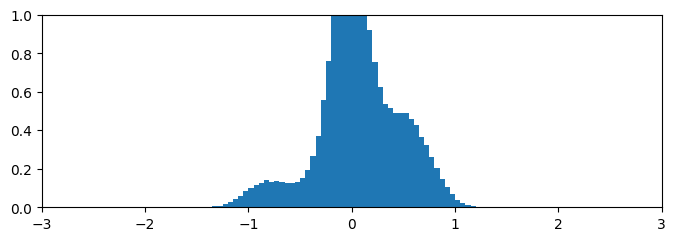

In [27]:
sigma = 0.12288
n_samples = 100_000
samples=sample_from_timemunet(time_mu_net,T,sigma,n_samples)
samples = samples

# Plot the data
sampled_data = samples[0,:]
bins = np.arange(-3,3.05,0.05)

fig,ax = plt.subplots()
fig.set_size_inches(8,2.5)
ax.set_xlim([-3,3])
plt.hist(sampled_data, bins=bins, density =True)
ax.set_ylim(0, 1.0)
plt.show()

While its not quite as good as when we had 100 MuNets, with a bit of scale and hyperparemeter tuning we could improve the results.

## Guidance

So far we've created unconditional diffusion models; we don't have control over what they produce. A really powerful and useful technique to give us more control over our models is guidance. We'll start with _classifier guidance_ which can turn an unconditional model into a conditional one and then look at _classifier-free guidance_ which can be used to improve the quality of a conditional model.

### Classifier Guidance

Lets imagine that we have an unconditional diffusion model trained on images of cats and dogs. However we'd like to control when we sample images of cats and when we sample images of dogs. If we have an image classifier that can tell cats and dogs apart we can input the current $z_{t-1}$ and a loss against the desired class (cat or dog). Since the image classifier is a Neural Network it is necessarily differentiable, hence we can calculate the gradient of the loss with respect to the image $\dfrac{\partial L}{\partial z_{t-1}}$. Then we adjust $z_{t-1}$:<br/> 

$z_{t-1}\gets z_{t-1}-\eta \dfrac{\partial L}{\partial z_{t-1}}$, where $\eta$ controls the strength of the guidance.

If we keep doing this as we generate samples we'll only generate the desired class.

In our simple setting we could just target one specific value with the classifier: $(c-z_{t-1})^{2}$, where $c$ is the desired value.

In [28]:
def classifier_grad(target,z_t_minus_1):
    return -2*target + 2*z_t_minus_1 

In [29]:
def sample_with_classifier_guidance(model,T,sigma_t,n_samples,target,eta):
    # Create the output array
    # Each row represents a time step, first row will be sampled data
    # Each column represents a different sample
    samples = np.zeros((T+1,n_samples))

    #Initialize the samples z_{T} at samples[T,:] from standard normal distribution
    samples[T,:]=np.random.normal(size=n_samples)
    model.eval()
    with torch.no_grad():
    # For t=100...99..98... ...0
        for t in range(T,0,-1):
            clear_output(wait=True)
            display("Predicting z_{%d} from z_{%d}"%(t-1,t))
            #Predict samples[t-1,:] from samples[t,:] using the appropriate model
        
            torch_inputs = torch.tensor(samples[t,:],device=device,dtype=torch.float32).view(n_samples,1)
            samples[t-1,:] = model(torch_inputs,torch.tensor(n_samples*[t-1],device=device)).cpu().numpy().squeeze()


            # If not the last time step
            if t>0:
                # TODO Add noise to the samples at z_t-1 we just generated with mean zero, standard deviation sigma_t
                samples[t-1,:] = samples[t-1,:] + np.random.normal(loc=0,scale=sigma_t,size=n_samples)
                samples[t-1,:] = samples[t-1,:] - eta* classifier_grad(target,samples[t-1,:])

    return samples

'Predicting z_{0} from z_{1}'

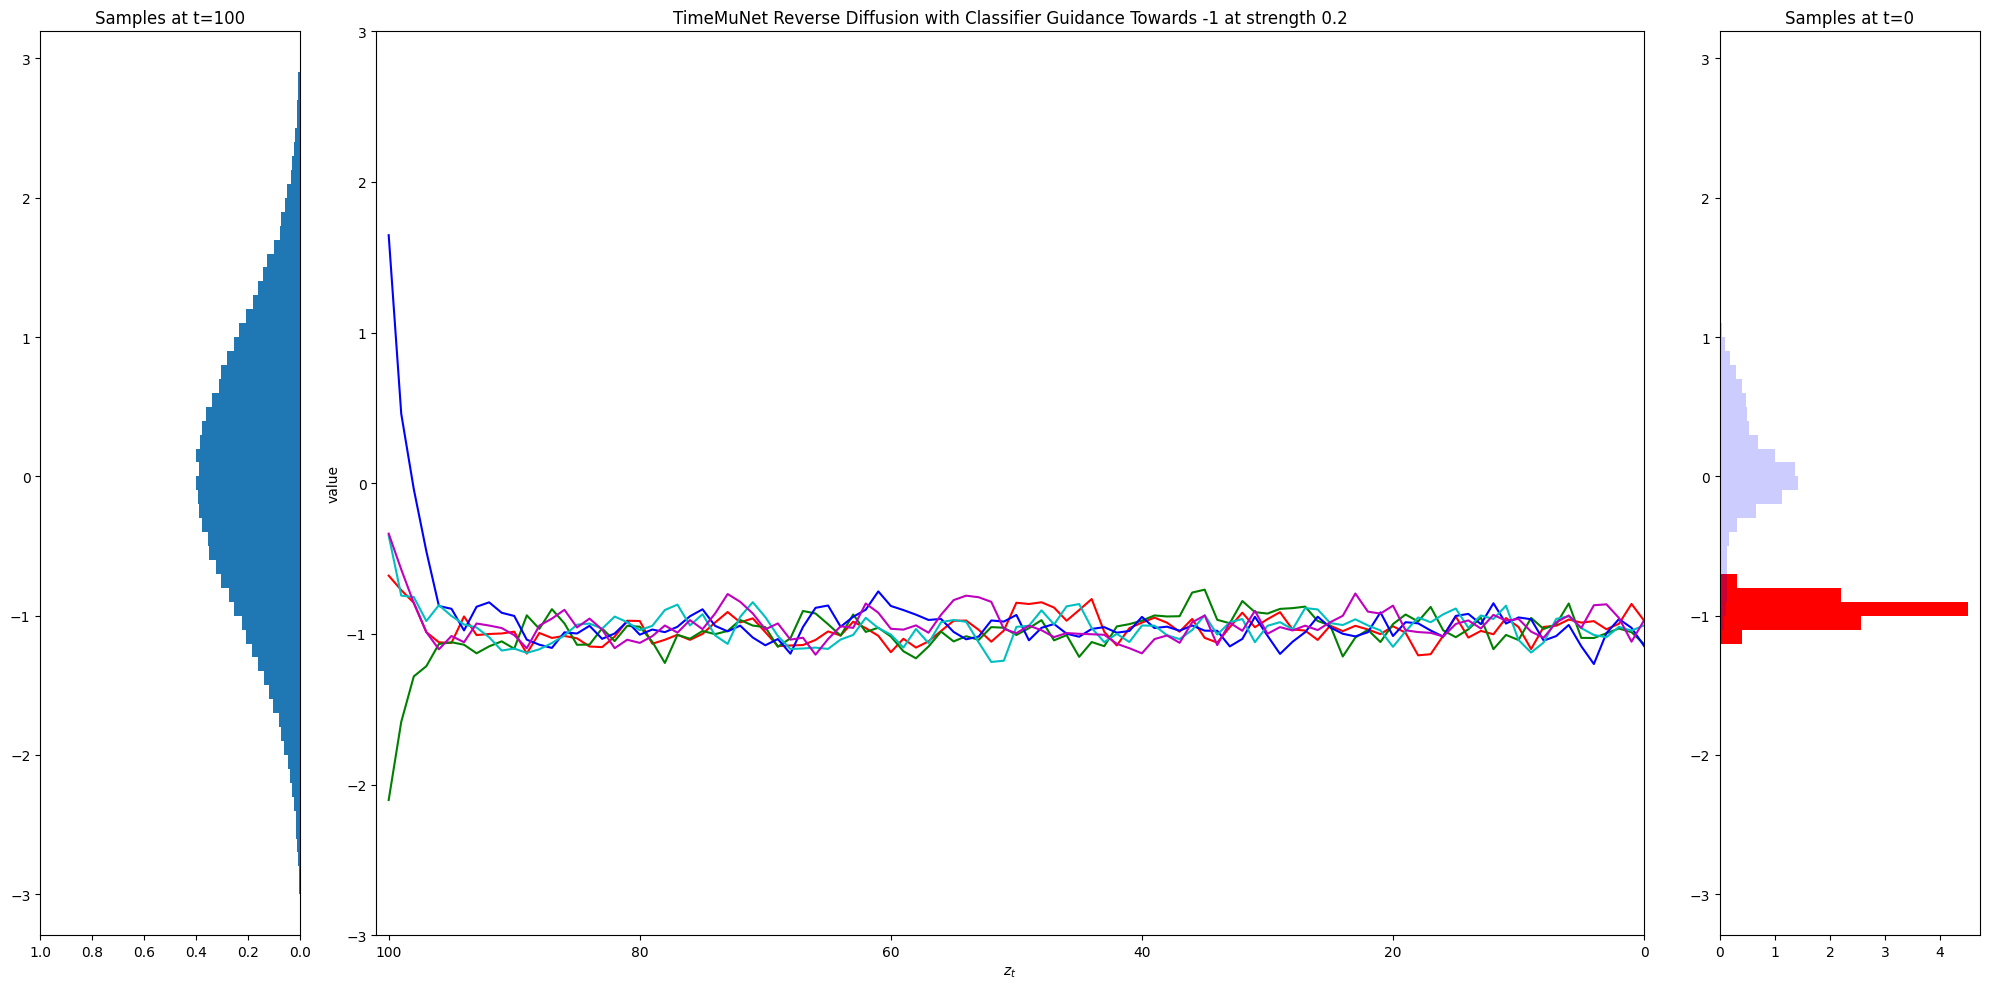

In [30]:
sigma = 0.12288
n_samples = 100_000
eta=0.2
target=-1
guided_samples=sample_with_classifier_guidance(time_mu_net,T,sigma,n_samples,target,eta)
guided_samples = guided_samples

fig = plt.figure(figsize=(20, 10))
axs=fig.subplot_mosaic("""ABBBBC
""")

axs["A"].set_title('Samples at t=100')
axs["A"].hist(guided_samples[100,:] , bins=np.arange(-3,3, 0.1), density = True,orientation='horizontal')
axs["A"].set_xlim(1.0,0)

axs["C"].set_title('Samples at t=0')
axs["C"].hist(guided_samples[0,:] , bins=np.arange(-3,3, 0.1), density = True,orientation='horizontal',color='red')
axs["C"].hist(samples[0,:] , bins=np.arange(-3,3, 0.1), density = True,orientation='horizontal',fc=(0, 0, 1, 0.2))

t_vals = np.arange(0,T+1,1)
axs["B"].set_title(f"TimeMuNet Reverse Diffusion with Classifier Guidance Towards {target} at strength {eta}")
axs["B"].plot(t_vals,guided_samples[:,0],'r-')
axs["B"].plot(t_vals,guided_samples[:,1],'g-')
axs["B"].plot(t_vals,guided_samples[:,2],'b-')
axs["B"].plot(t_vals,guided_samples[:,3],'c-')
axs["B"].plot(t_vals,guided_samples[:,4],'m-')
axs["B"].set_ylim([-3,3])
axs["B"].set_xlim([T+1,0])
axs["B"].set_ylabel('value')
axs["B"].set_xlabel(f'$z_{"t"}$')
plt.tight_layout()
plt.show()

With basic maths we've turned our unconditional model into a conditional model! What you'll also notice by trying different values of $\eta$, is that there is an inherent tradeoff between sample diversity and control. Whilst this works quite nicely in our setting, in practice it can be quite expensive to use Classifier Guidance. Typically, if all you want is a conditional model, that conditioning is added to the model directly. 

However, _guidance_ can also be used to improve the quality of a model's output. Imagine for a moment that the peaks of our learnt distribution represent different classes, so any samples between the peaks could be understood as some kind of interpolation between classes (e.g. a cat-dog hybrid). This may often be undesirable. We could try to drastically penalise our model for predicting the wrong class during training however that would quite quickly destroy sample diversity. Rather we want to be able to provide conditioning, and, at _inference_, control how closely we adhere to it, allowing us to trade quality for sample diversity as we please. We could achieve this with a conditional model and Classifier Guidance. However, there's technique that is typically computationally less expensive called 'Classifier-Free Guidance'.

### Classifier-Free Guidance
In Classifer-Free Guidance, we train our diffusion model with conditioning but drop the conditioning with some probability $p_{\text{uncond}}$. When performing inference we start with the same noise sample $z_{T}\sim\mathcal{N}(0,\mathbf{I})$ and duplicate it. Next we add conditioning to one of the $z_{T}\text{s}$ and null-conditioning (i.e. no conditioning) to the other. Next we run this batch of 2 samples through our neural network and obtain $\hat{z}^{c}_{t-1}$ (our sampled $z_{t-1}$ with conditioning) and $\hat{z}^{\emptyset}_{t-1}$ (our sampled $z_{t-1}$ without conditioning). We then adjust $\hat{z}^{c}_{t-1}$ as follows: <br/>

$\hat{z}^{c}_{t-1}\gets (1+\omega)\hat{z}^{c}_{t-1}-\omega\hat{z}^{\emptyset}_{t-1}$, where $\omega$ controls the strength of the guidance. 
This adjustment is repeated throughout the reverse sampling stage until we reach $t=0$.

Pretty simple right? All we need is a way to condition our diffusion model and boom, we're in business! Since we're in such a simple setting, I'll make each of the three largest peaks a class and we'll label training examples as belonging to the class associated with the peak that it is closest to. The typical way that we'd specify this kind of conditioning to the model is via a one-hot encoded vector of dimension 3. So far example, class 1 is $\begin{bmatrix}1 \\ 0 \\ 0 \end{bmatrix}$ and class 3 is $\begin{bmatrix}0 \\ 0 \\ 1 \end{bmatrix}$. This representation is ideal since the absence of conditioning can simply be specified by $\begin{bmatrix}0 \\ 0 \\ 0 \end{bmatrix}$.

This all requires a tiny change to our TimeMuNet and a few changes to how we train the model.

In [31]:
class ConditionalTimeMuNet(nn.Module):
    def __init__(self, h,p_dropout):
        super().__init__()
        self.h=h
        self.layer1 = nn.Sequential(
            nn.Linear(4,2*h),#Change the expect input dim to 4
            nn.ReLU(),
        )
        self.dropout = nn.Dropout(p=p_dropout)
        self.last_layers = nn.Sequential(
            nn.Linear(2*h,h),
            nn.ReLU(),
            nn.Linear(h,1),
        )
    # Same function as before except now our half dim is h
    def get_timestep_embedding(self,timesteps):
        timesteps=timesteps.squeeze()
        half_dim = self.h#//2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, dtype=torch.float32) * -emb)
        emb = emb.to(device=timesteps.device)
        emb = timesteps.float()[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
        if self.h % 2 == 1:  # zero pad
            emb = torch.nn.functional.pad(emb, (0,1,0,0))
        return emb
    
    def forward(self,x,c,t):
        #All we need to do now is concatenate on our onehot conditioning
        x= torch.concat([x,c],dim=1) #(Batch Size,4)
        hidden = self.dropout(self.layer1(x))
        time_embedding = self.get_timestep_embedding(t) 
        hidden = hidden + time_embedding
        return self.last_layers(hidden)

In [47]:
def get_class(x):
    #1.5, -0.216, -1.875
    #0.75, -0.108, -0.9375
    #class_label = torch.zeros((x.shape[0],3),device=device)
    distances = torch.cat([torch.square(x-0.75),torch.square(x+0.108),torch.square(x+0.9375)],dim=1)
    #print(distances)
    idx = torch.argmin(distances,dim=1)#dim=0
    # print(idx)
    #class_label = 
    #class_label[idx]=1
    
    return torch.nn.functional.one_hot(idx,num_classes=3).to(device,dtype=torch.float32)#class_label.index_fill_(0,idx,1)

In [109]:
import os
os.environ['CUDA_LAUNCH_BLOCKING']='1'

cond_time_mu_net = ConditionalTimeMuNet(h=256,p_dropout=0.1).to(device)
n_samples = 200_000
p_uncond = 0.2
x_train = np.array(true_dist.sample(n_samples))
x_train = (1/2)*(x_train)
batch_size = 4096
n_epochs= 100
beta = 0.01511 #Variance of forward process
sigma = 0.12288  #Std of reverse process
lr=1e-4

time_mu_net.train()
optimiser = torch.optim.AdamW(cond_time_mu_net.parameters(),lr=lr)
for e in range(n_epochs):
    print(f"*****Epoch {e}*****")
    running_loss = 0
    np.random.shuffle(x_train)

    for i in range(n_samples//batch_size+1):
        optimiser.zero_grad()
        batch_min_idx = i*batch_size
        batch_max_idx = min(n_samples-1,(i+1)*batch_size)
        inputs = torch.tensor(x_train[batch_min_idx:batch_max_idx],device=device,dtype=torch.float32).unsqueeze(1)
        #For the first ten epochs we'll just train completely unconditionally
        if e>=10:
            #Inefficient but doesn't really matter
            #print(inputs)
            class_labels = get_class(inputs)#map(get_class,inputs)
            #print(class_labels)
            #Use functional dropout to drop conditioning. By default this scales the inputs by 1/((1-p_uncond)), 
            #so we undo this scaling
            class_labels=(1-p_uncond)*torch.nn.functional.dropout(class_labels,p=p_uncond)
            #print(class_labels)
            #break
        else:
            class_labels = torch.zeros((inputs.shape[0],3),device=device,dtype=torch.float32)
        
        timesteps = torch.randint_like(inputs,low=1,high=T,device=device).long()
        alpha_t = get_alpha_t(timesteps,beta)
       
        alpha_t_minus_1 = get_alpha_t_minus_1(timesteps,beta)

        noised_inputs = torch.sqrt(alpha_t)*inputs + torch.sqrt(1-alpha_t)*torch.randn_like(inputs)
        labels = (
            (noised_inputs*(1-alpha_t_minus_1)/(1-alpha_t))*torch.sqrt(torch.tensor(1-beta,device=device)) + ((inputs*torch.sqrt(alpha_t_minus_1)*beta)/(1-alpha_t)))
        outputs=cond_time_mu_net(noised_inputs,class_labels,timesteps)
        loss = torch.nn.functional.mse_loss(outputs,labels)
      
        loss.backward()
        optimiser.step()
        running_loss += loss.item()
    
        if i%10==0:
            print(f'[Epoch: {e+1}/{n_epochs} Batch {i}] Loss: {running_loss/100}')
            running_loss=0
    clear_output(wait=True)
    #break



*****Epoch 99*****
[Epoch: 100/100 Batch 0] Loss: 7.895283051766455e-06
[Epoch: 100/100 Batch 10] Loss: 7.72063247859478e-05
[Epoch: 100/100 Batch 20] Loss: 7.586813298985363e-05
[Epoch: 100/100 Batch 30] Loss: 7.480204803869128e-05
[Epoch: 100/100 Batch 40] Loss: 7.340481970459223e-05


In [106]:
def sample_with_classifier_free_guidance(model,T,sigma_t,n_samples,starting_noise,class_labels,omega):
    # Create the output array
    # Each row represents a time step, first row will be sampled data
    # Each column represents a different sample
    conditional_samples = np.zeros((T+1,n_samples))
    #unconditional_samples = np.zeros((T+1,n_samples))
    class_labels = torch.tensor(class_labels,device=device,dtype=torch.float32)
    null_conditioning = torch.zeros((n_samples,3),device=device,dtype=torch.float32)

    #Initialize the samples z_{T} at samples[T,:] from standard normal distribution
    conditional_samples[T,:]=starting_noise#np.random.normal(size=n_samples)
    #unconditional_samples[T,:]=conditional_samples[T,:].copy()
    model.eval()
    with torch.no_grad():
    # For t=100...99..98... ...0
        for t in range(T,0,-1):
            clear_output(wait=True)
            display("Predicting z_{%d} from z_{%d}"%(t-1,t))
            timesteps = torch.tensor(n_samples*[t-1],device=device)
            torch_conditional_inputs = torch.tensor(conditional_samples[t,:],device=device,dtype=torch.float32).view(n_samples,1)
           # torch_unconditional_inputs = torch.tensor(unconditional_samples[t,:],device=device,dtype=torch.float32).view(n_samples,1)
            

            conditional_samples[t-1,:] = model(torch_conditional_inputs,class_labels,timesteps).cpu().numpy().squeeze()
            unconditional_z_t_minus_one = model(torch_conditional_inputs,null_conditioning,timesteps).cpu().numpy().squeeze()
            
           # unconditional_samples[t-1,:] = model(torch_unconditional_inputs,null_conditioning,timesteps).cpu().numpy().squeeze()

            conditional_samples[t-1,:] = (1+omega)*conditional_samples[t-1,:] - omega*unconditional_z_t_minus_one#unconditional_samples[t-1,:]
            # If not the last time step
            if t>0:
                conditional_samples[t-1,:] = conditional_samples[t-1,:] + np.random.normal(loc=0,scale=sigma_t,size=n_samples)
                #unconditional_samples[t-1,:] = unconditional_samples[t-1,:] + np.random.normal(loc=0,scale=sigma_t,size=n_samples)

              


    return conditional_samples#,unconditional_samples

In [107]:
def sample_from_cond_time_mu_net_unconditionally(model,T,sigma_t,n_samples,starting_noise):
    null_conditioning = torch.zeros((n_samples,3),device=device,dtype=torch.float32)
    unconditional_samples = np.zeros((T+1,n_samples))
    unconditional_samples[T,:]=starting_noise
    model.eval()
    with torch.no_grad():
    # For t=100...99..98... ...0
        for t in range(T,0,-1):
            clear_output(wait=True)
            display("Predicting z_{%d} from z_{%d}"%(t-1,t))
            timesteps = torch.tensor(n_samples*[t-1],device=device)
            torch_unconditional_inputs = torch.tensor(unconditional_samples[t,:],device=device,dtype=torch.float32).view(n_samples,1)
            unconditional_samples[t-1,:] = model(torch_unconditional_inputs,null_conditioning,timesteps).cpu().numpy().squeeze()

            # If not the last time step
            if t>0:
                unconditional_samples[t-1,:] = unconditional_samples[t-1,:] + np.random.normal(loc=0,scale=sigma_t,size=n_samples)
    return unconditional_samples

'Predicting z_{0} from z_{1}'

Red guided towards -0.9375
Green guided towards 0.75
Blue guided towards 0.75
Cyan guided towards -0.108


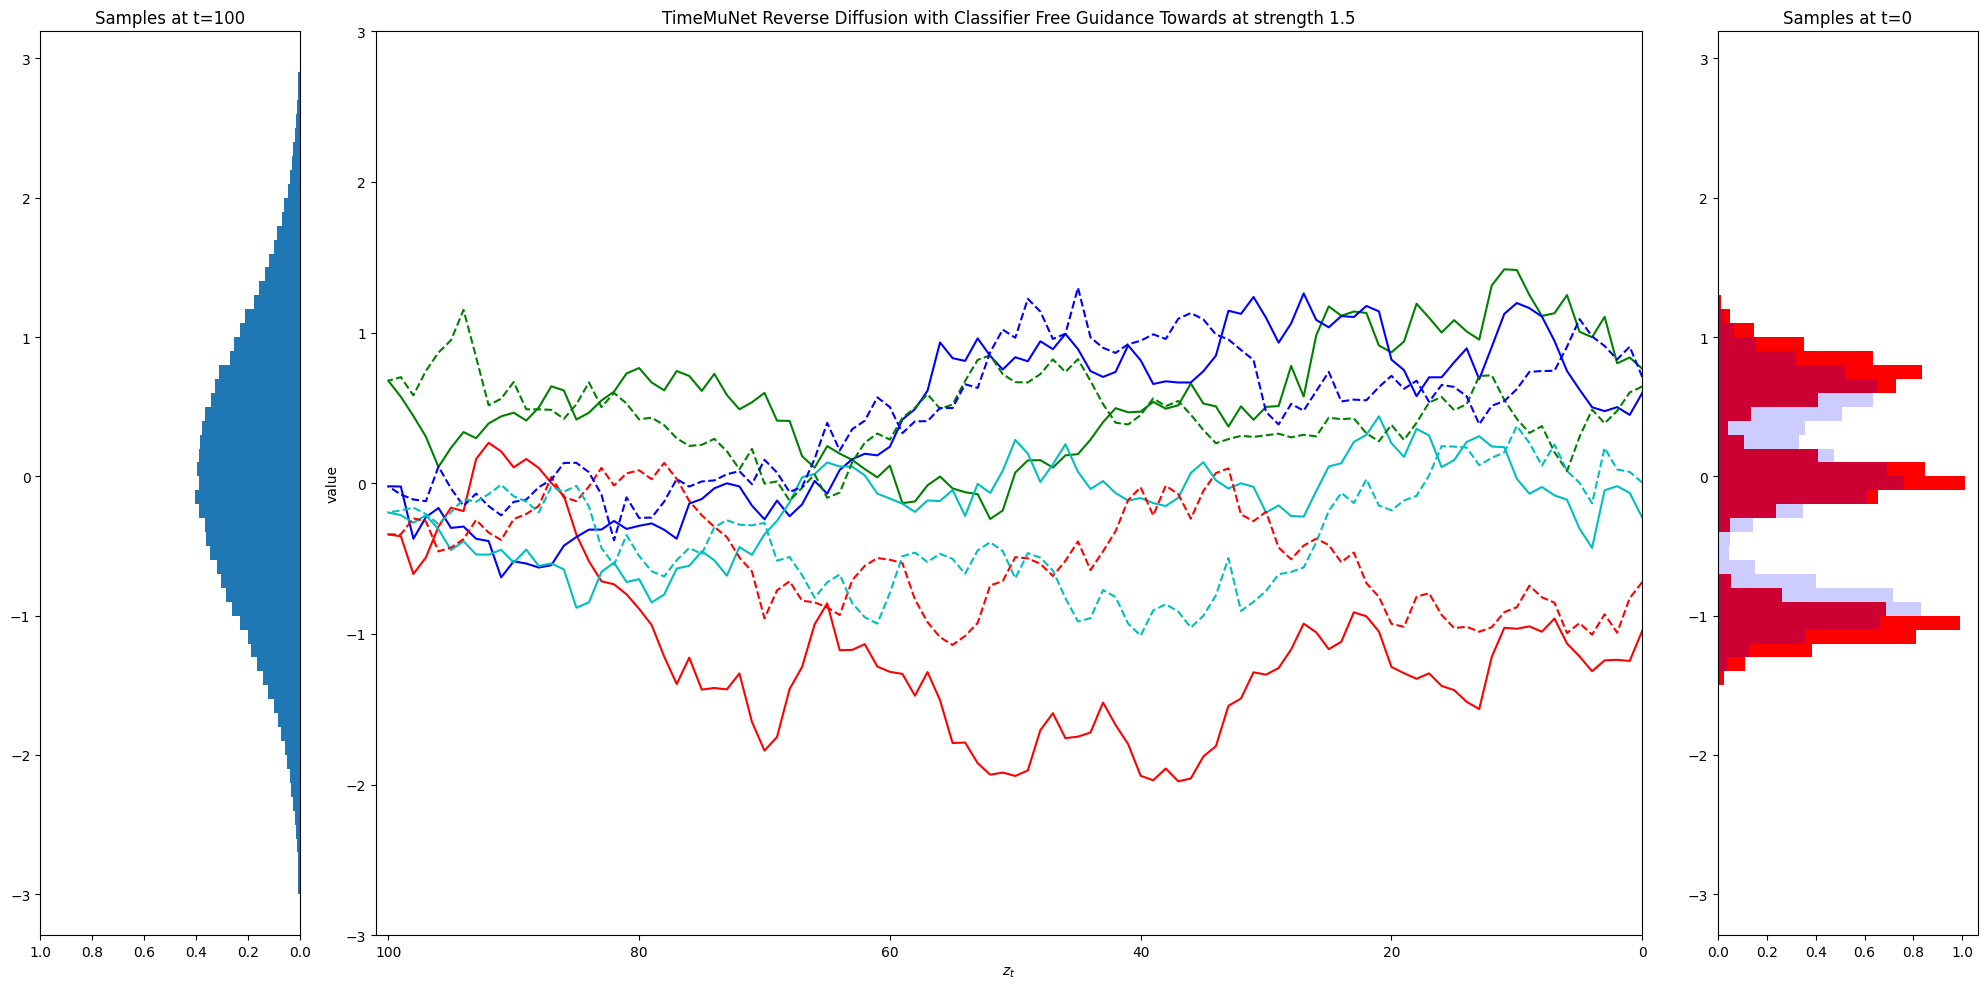

In [123]:
sigma = 0.12288
n_samples = 120_000
omega=1.2
class_labels = 40_000*[[1,0,0]] + 40_000*[[0,1,0]] + 40_000*[[0,0,1]]
np.random.seed(64)
np.random.shuffle(class_labels)
starting_noise = np.random.normal(size=n_samples)
guided_samples=sample_with_classifier_free_guidance(cond_time_mu_net,T,sigma,n_samples,starting_noise,class_labels,omega)
unconditional_samples=sample_with_classifier_free_guidance(cond_time_mu_net,T,sigma,n_samples,starting_noise,class_labels,0)

#sample_from_cond_time_mu_net_unconditionally(cond_time_mu_net,T,sigma,n_samples,starting_noise) 
#guided_samples=unconditional_samples

fig = plt.figure(figsize=(20, 10))
axs=fig.subplot_mosaic("""ABBBBC
""")
#0.75, -0.108, -0.9375
class_label_vals = [0.75, -0.108, -0.9375]
axs["A"].set_title('Samples at t=100')
axs["A"].hist(guided_samples[100,:] , bins=np.arange(-3,3, 0.1), density = True,orientation='horizontal')
axs["A"].set_xlim(1.0,0)

axs["C"].set_title('Samples at t=0')
axs["C"].hist(guided_samples[0,:] , bins=np.arange(-3,3, 0.1), density = True,orientation='horizontal',color='red')
axs["C"].hist(unconditional_samples[0,:] , bins=np.arange(-3,3, 0.1), density = True,orientation='horizontal',fc=(0, 0, 1, 0.2))

t_vals = np.arange(0,T+1,1)
axs["B"].set_title(f"TimeMuNet Reverse Diffusion with Classifier Free Guidance Towards at strength {omega}")
print(f"Red guided towards {class_label_vals[np.argmax(class_labels[0])]}")
print(f"Green guided towards {class_label_vals[np.argmax(class_labels[1])]}")
print(f"Blue guided towards {class_label_vals[np.argmax(class_labels[2])]}")
print(f"Cyan guided towards {class_label_vals[np.argmax(class_labels[3])]}")
# print(f"Magenta guided towards {class_label_vals[np.argmax(class_labels[4])]}")
axs["B"].plot(t_vals,guided_samples[:,0],'r-')
axs["B"].plot(t_vals,guided_samples[:,1],'g-')
axs["B"].plot(t_vals,guided_samples[:,2],'b-')
axs["B"].plot(t_vals,guided_samples[:,3],'c-')

axs["B"].plot(t_vals,unconditional_samples[:,0],'r--')
axs["B"].plot(t_vals,unconditional_samples[:,1],'g--')
axs["B"].plot(t_vals,unconditional_samples[:,2],'b--')
axs["B"].plot(t_vals,unconditional_samples[:,3],'c--')

# axs["B"].plot(t_vals,guided_samples[:,4],'m-')
axs["B"].set_ylim([-3,3])
axs["B"].set_xlim([T+1,0])
axs["B"].set_ylabel('value')
axs["B"].set_xlabel(f'$z_{"t"}$')
plt.tight_layout()
plt.show()